In [1]:
import logging
import os
import re
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import numpy as np
import pandas as pd
import scgen
import scanpy as sc
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import umap

/home/estorrs/miniconda3/envs/scgen/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Using TensorFlow backend.
/home/estorrs/miniconda3/envs/scgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/estorrs/miniconda3/envs/scgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/estorrs/miniconda3/envs/scgen/lib/python3.7/s

In [ ]:
directory = '/home/estorrs/data/single_cell_classification/tumor/CCRCC/yige/seperate/'
sample_fps_tups = [(fp.split('.')[0], os.path.join(directory, fp)) for fp in os.listdir(directory)]
sample_fps_tups

In [ ]:
col_order = 

In [ ]:
sample_to_df = {s:pd.read_csv(fp, sep='\t').transpose() for s, fp in sample_fps_tups}
sample_to_df.keys()

In [ ]:
list(sample_to_df.values())[0]

In [ ]:
master = None
for sample, df in sample_to_df.items():
    print(sample)
    df.index = [f'{sample}_{c}' for c in df.index]
    if master is None:
        master = df
    else:
        master = pd.concat((master, df))
master

In [ ]:
metadata = pd.read_csv('/home/estorrs/data/single_cell_classification/tumor/CCRCC/yige/metadata.tsv',
                         sep='\t')
cell_ids = [f'{s}_{c}' for c, s in zip(metadata['cell_id'], metadata['sample_id'])]
metadata.index = cell_ids
metadata.index.name = 'id'
metadata = metadata.loc[master.index]
metadata

In [ ]:
adata = anndata.AnnData(X=master.values, obs=metadata)
adata.obs.index = master.index
adata.var.index = master.columns
adata

In [ ]:
counts = Counter(adata.obs['cell_type'])
counts.most_common()

In [ ]:
## get rid of unknowns
adata = adata[adata.obs['cell_type']!='Unknown']
adata

In [ ]:
adata

In [ ]:
adata.write_h5ad('/home/estorrs/data/single_cell_classification/tumor/CCRCC/yige/adata.h5')

In [ ]:
adata = anndata.read_h5ad('/home/estorrs/data/single_cell_classification/tumor/CCRCC/yige/adata.h5')
adata

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [ ]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

In [ ]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)
adata.raw = adata

In [ ]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=10., min_disp=0.2)
sc.pl.highly_variable_genes(adata)

In [ ]:
adata

In [ ]:
np.count_nonzero(adata.var['highly_variable'])

In [ ]:
adata = adata[:, adata.var.highly_variable]
adata

In [ ]:
sc.pp.scale(adata, max_value=8)
adata

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color=['cell_type', 'sample_id'], ncols=1)

In [ ]:
cell_type_key='cell_type'

In [ ]:
import random

In [ ]:
import random
## filter smartly
n = 500

cell_type_to_idxs = {}
for cell_id, cell_type in zip(adata.obs.index, adata.obs[cell_type_key]):
    if cell_type not in cell_type_to_idxs:
        cell_type_to_idxs[cell_type] = [cell_id]
    else:
        cell_type_to_idxs[cell_type].append(cell_id)
        
def temp(ls):
    if len(ls) > n:
        return random.sample(ls, n)
    return random.sample(ls, int(len(ls) * .8))

cell_type_to_idxs = {k:temp(ls)
                     for k, ls in cell_type_to_idxs.items()}

train_idxs = np.asarray([x for ls in cell_type_to_idxs.values() for x in ls])
train_idxs = np.arange(adata.shape[0])[np.isin(np.asarray(adata.obs.index), train_idxs)]
val_idxs = np.delete(np.arange(adata.shape[0]), train_idxs)

test_idxs = random.sample(list(val_idxs), k=5000)

train_idxs.shape, val_idxs.shape

In [ ]:
train_adata = adata[train_idxs, :].copy()
val_adata = adata[val_idxs, :].copy()
test_adata = adata[test_idxs, :].copy()

In [ ]:
Counter(train_adata.obs[cell_type_key]).most_common()

In [ ]:
scg = scgen.VAEArith(x_dimension= train_adata.shape[1], model_path="/home/estorrs/pollock/models/ccrcc_human_vae" )

In [ ]:
%%time
history = scg.train(train_data=train_adata, use_validation=True, valid_data=test_adata, n_epochs=15,
                   verbose=True)

In [ ]:
train_embeddings = scg.to_latent(train_adata.X)
val_embeddings = scg.to_latent(val_adata.X)

In [ ]:
encoder = OrdinalEncoder()
y_train = encoder.fit_transform(np.asarray(train_adata.obs[cell_type_key]).reshape(-1, 1)).flatten()
y_val = encoder.transform(np.asarray(val_adata.obs[cell_type_key]).reshape(-1, 1)).flatten()

In [ ]:
clf = RandomForestClassifier()

In [ ]:
%%time
clf.fit(train_embeddings, y_train)

In [ ]:
clf.score(val_embeddings, y_val)

In [ ]:
preds = clf.predict(val_embeddings)

In [ ]:
c_mat = confusion_matrix(y_val, preds)
c_mat = c_mat / np.sum(c_mat, axis=1).reshape(-1, 1)
c_mat = (c_mat * 100).astype(np.int32)

In [ ]:
plt.figure(figsize=(10, 9))
sns.heatmap(c_mat, xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0],
           cmap='Blues',annot=True, fmt='d')
plt.xlabel('predicted')
plt.xlabel('true')
plt.tight_layout()
plt.savefig('ccrcc_confusion_matrix.png')

In [ ]:
cell_embeddings = scg.to_latent(adata.X)
cell_embeddings

In [ ]:
adata.obsm['scgen_embeddings'] = cell_embeddings
adata

In [ ]:
predicted_cell_types = [encoder.categories_[0][int(i)] for i in clf.predict(cell_embeddings)]
adata.obs['predicted_cell_type'] = predicted_cell_types

In [ ]:
adata.obsm['scgen_umap'] = umap.UMAP().fit_transform(adata.obsm['scgen_embeddings'])
adata

In [ ]:
adata.obs['scgen_umap1'] = adata.obsm['scgen_umap'][:, 0]
adata.obs['scgen_umap2'] = adata.obsm['scgen_umap'][:, 1]

In [ ]:
sc.pl.scatter(adata[val_idxs], x='scgen_umap1', y='scgen_umap2', color='cell_type',
             frameon=False)

## transfer to mouse

In [87]:
human_adata = anndata.read_h5ad('/home/estorrs/data/single_cell_classification/tumor/CCRCC/yige/adata.h5')
human_adata

AnnData object with n_obs × n_vars = 130429 × 32798 
    obs: 'cell_id', 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes'
    var: 'n_cells'

In [88]:
sc.pp.filter_cells(human_adata, min_genes=200)
sc.pp.filter_genes(human_adata, min_cells=3)

In [89]:
mito_genes = human_adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
# human_adata.obs['percent_mito'] = np.sum(
#     human_adata[:, mito_genes].X, axis=1) / np.sum(human_adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
human_adata.obs['n_counts'] = human_adata.X.sum(axis=1)

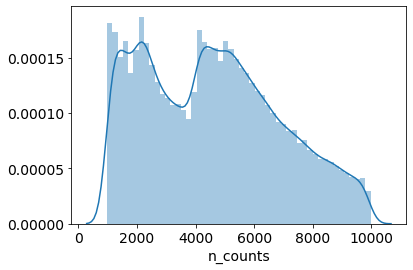

In [91]:
sns.distplot(human_adata.obs['n_counts'])

In [ ]:
directory = '/home/estorrs/data/pdx/ccrcc/'
mouse_fps = [os.path.join(directory, fp) for fp in os.listdir(directory)]
mouse_fps

In [ ]:
adatas = []
for fp in mouse_fps:
    sample = fp.split('/')[-1]
    temp = sc.read_10x_mtx(
        fp,  # the directory with the `.mtx` file
        var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
        cache=True)                                # write a cache file for faster subsequent reading
    temp.obs['sample_id'] = [sample] * temp.shape[0]
    sc.pp.filter_cells(temp, min_genes=200)
    print(sample)
    print(temp.shape)
    adatas.append(temp.copy())
len(adatas)

In [ ]:
for adata in adatas: print(adata.shape)

In [ ]:
mouse_adata = adatas[0].concatenate(*adatas[1:])
mouse_adata

In [ ]:
mouse_adata.write_h5ad('/home/estorrs/data/pdx/ccrcc/combined.h5')

In [145]:
mouse_adata = anndata.read_h5ad('/home/estorrs/data/pdx/ccrcc/combined.h5')
mouse_adata.X = mouse_adata.X.toarray()
mouse_adata

AnnData object with n_obs × n_vars = 182825 × 33538 
    obs: 'batch', 'n_genes', 'sample_id'
    var: 'gene_ids', 'feature_types'

In [ ]:
mouse_adata.obs

In [ ]:
len(set(mouse_adata.obs.index))

In [ ]:
mouse_adata.var

In [146]:
mouse_adata = mouse_adata[mouse_adata.obs['sample_id'] == 'RESL10F-12462-CT2']

In [147]:
sc.pp.filter_cells(mouse_adata, min_genes=200)
sc.pp.filter_genes(mouse_adata, min_cells=3)

Trying to set attribute `.obs` of view, copying.


In [148]:
mito_genes = mouse_adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
mouse_adata.obs['percent_mito'] = np.sum(
    mouse_adata[:, mito_genes].X, axis=1) / np.sum(mouse_adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
mouse_adata.obs['n_counts'] = mouse_adata.X.sum(axis=1)

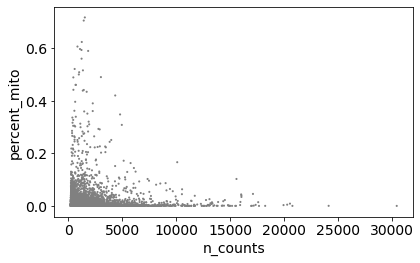

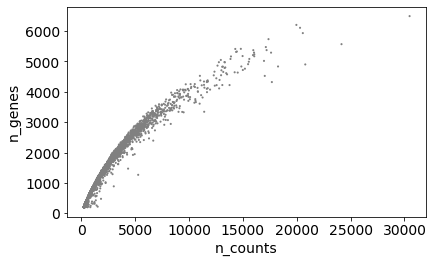

In [149]:
sc.pl.scatter(mouse_adata, x='n_counts', y='percent_mito')
sc.pl.scatter(mouse_adata, x='n_counts', y='n_genes')

In [150]:
mouse_adata = mouse_adata[mouse_adata.obs.n_genes < 6000, :]
mouse_adata = mouse_adata[mouse_adata.obs.percent_mito < 0.1, :]

In [151]:
sc.pp.normalize_total(mouse_adata, target_sum=1e4)
sc.pp.log1p(mouse_adata)
mouse_adata.raw = mouse_adata

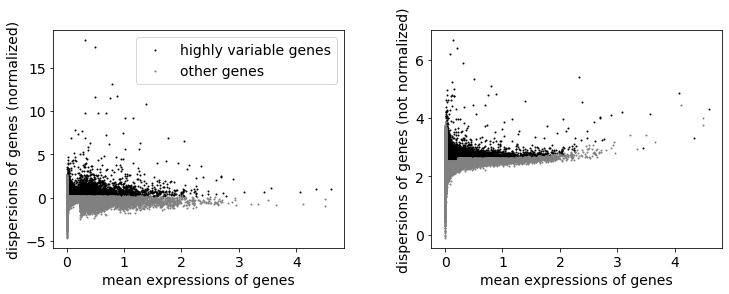

In [154]:
sc.pp.highly_variable_genes(mouse_adata, min_mean=0.0125, max_mean=10., min_disp=0.2)
# sc.pp.highly_variable_genes(mouse_adata, min_mean=0.0, max_mean=2, min_disp=.5)

sc.pl.highly_variable_genes(mouse_adata)

In [155]:
np.count_nonzero(mouse_adata.var['highly_variable'])

7343

In [156]:
mouse_adata = mouse_adata[:, mouse_adata.var.highly_variable]
mouse_adata

View of AnnData object with n_obs × n_vars = 6626 × 7343 
    obs: 'batch', 'n_genes', 'sample_id', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

In [157]:
# sc.pp.regress_out(mouse_adata, ['n_counts', 'percent_mito'])
sc.pp.scale(mouse_adata)
mouse_adata

/home/estorrs/miniconda3/envs/scgen/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:913: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 6626 × 7343 
    obs: 'batch', 'n_genes', 'sample_id', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

In [27]:
set(mouse_adata.obs['sample_id'])

{'RESL10F-12462-CT2',
 'RESL10F-12465-Sap2',
 'RESL10F-12467-Cabo2',
 'RESL10F-12473-Cabo_Sap2',
 'RESL5E-14529-Cabo_Sap2',
 'RESL5E-14539-Cabo2',
 'RESL5E-14541-CT2',
 'RESL5E-14542-Sap2'}

In [29]:
temp = mouse_adata[mouse_adata.obs['sample_id']=='RESL10F-12462-CT2']
temp

View of AnnData object with n_obs × n_vars = 6629 × 12096 
    obs: 'batch', 'n_genes', 'sample_id', 'percent_mito', 'n_counts', 'treatment', 'mouse', 'tumor', '__is_in_cluster__'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'sample_id_colors', 'treatment_colors', 'mouse_colors', 'tumor_colors', 'rank_genes_groups', 'rank_genes_groups_filtered'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [30]:
sc.tl.pca(temp, svd_solver='arpack')
sc.pp.neighbors(temp, n_neighbors=10, n_pcs=30)
sc.tl.umap(temp)

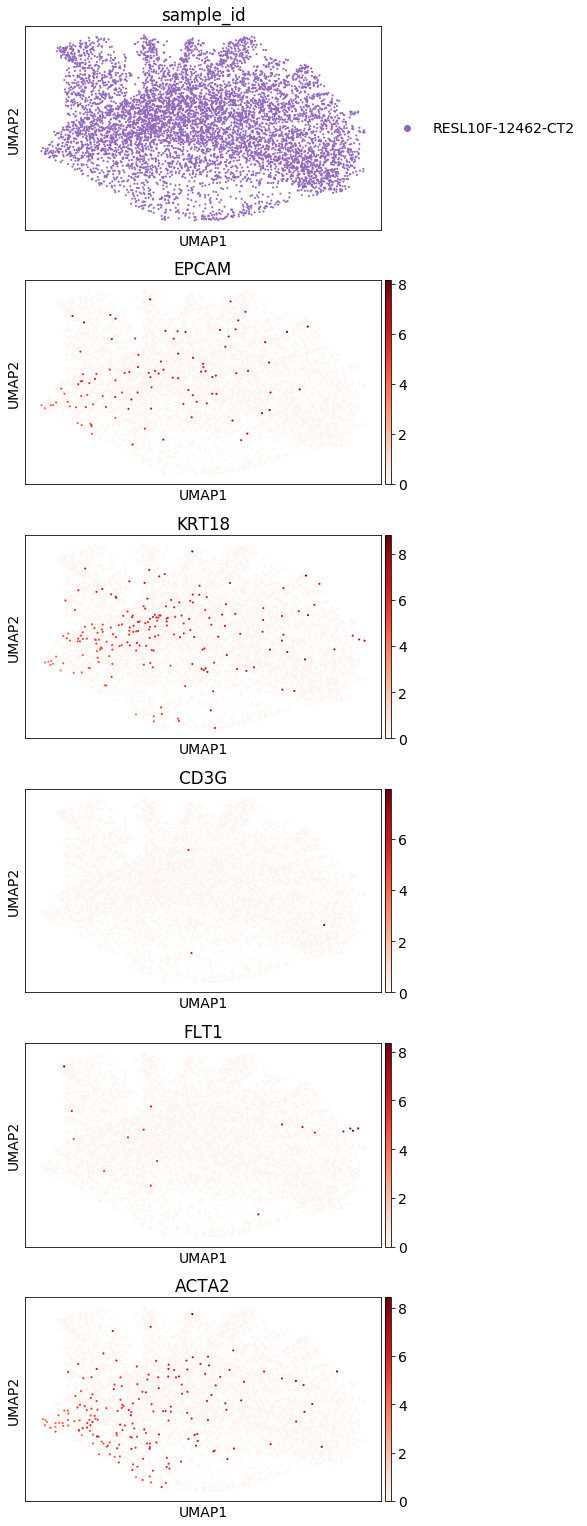

In [31]:
sc.pl.umap(temp, color=['sample_id', 'EPCAM', 'KRT18', 'CD3G', 'FLT1', 'ACTA2'], ncols=1, color_map='Reds')

In [122]:
mouse_adata.obs

,batch,n_genes,sample_id,percent_mito,n_counts
AAACCCAGTACTCGCG-1-1,1,1076,RESL10F-12462-CT2,0.009596,1459.0
AAACCCAGTATCGAAA-1-1,1,2849,RESL10F-12462-CT2,0.000576,5207.0
AAACCCAGTCACTACA-1-1,1,1627,RESL10F-12462-CT2,0.033813,2573.0
AAACCCAGTCCCACGA-1-1,1,486,RESL10F-12462-CT2,0.001701,588.0
AAACCCATCCTCATAT-1-1,1,345,RESL10F-12462-CT2,0.051095,411.0
...,...,...,...,...,...
TTTGTTGCATACCATG-1-1,1,2239,RESL10F-12462-CT2,0.008830,3624.0
TTTGTTGGTCGACTGC-1-1,1,1555,RESL10F-12462-CT2,0.048548,2410.0
TTTGTTGGTTTGACAC-1-1,1,1105,RESL10F-12462-CT2,0.000687,1456.0
TTTGTTGTCACTGAAC-1-1,1,939,RESL10F-12462-CT2,0.001660,1205.0


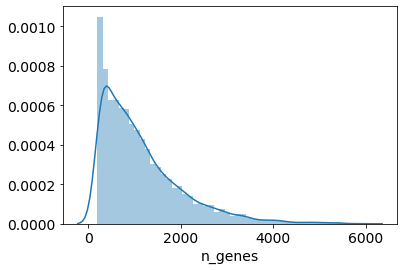

In [123]:
sns.distplot(mouse_adata.obs['n_genes'])

In [168]:
temp = mouse_adata.copy()

In [163]:
# temp = mouse_adata[mouse_adata.obs['n_genes'] > 4000]

In [169]:
sc.tl.pca(temp, svd_solver='arpack')

In [170]:
sc.pp.neighbors(temp, n_neighbors=10, n_pcs=30)

In [171]:
sc.tl.umap(temp)

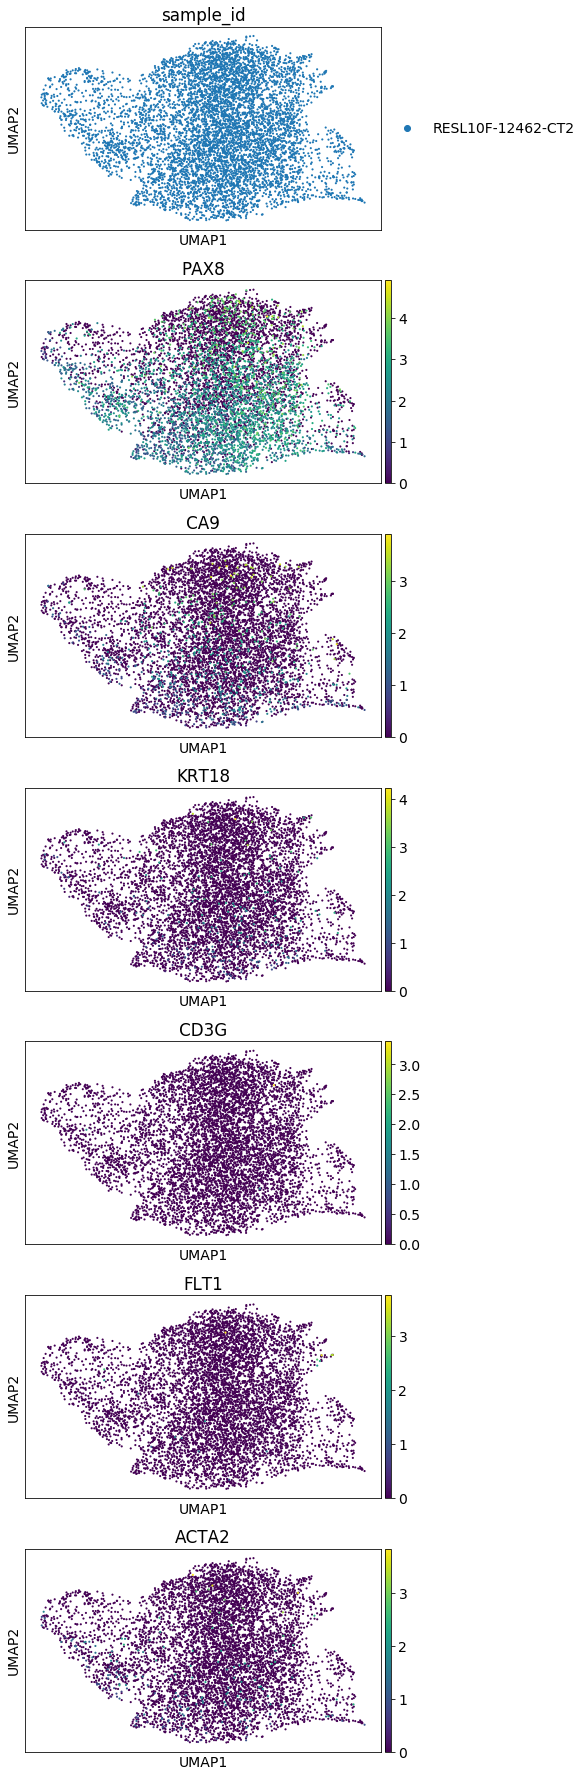

In [172]:
sc.pl.umap(temp, color=['sample_id', 'PAX8', 'CA9', 'KRT18', 'CD3G', 'FLT1', 'ACTA2'], ncols=1)

In [86]:
mouse_adata.obs['n_counts']

,batch,n_genes,sample_id,percent_mito,n_counts
AAACCCAGTACTCGCG-1-1,1,1076,RESL10F-12462-CT2,0.009596,1459.0
AAACCCAGTATCGAAA-1-1,1,2849,RESL10F-12462-CT2,0.000576,5207.0
AAACCCAGTCACTACA-1-1,1,1627,RESL10F-12462-CT2,0.033813,2573.0
AAACCCAGTCCCACGA-1-1,1,486,RESL10F-12462-CT2,0.001701,588.0
AAACCCATCCTCGATC-1-1,1,1535,RESL10F-12462-CT2,0.002225,2247.0
...,...,...,...,...,...
TTTGTTGCATACCATG-1-1,1,2239,RESL10F-12462-CT2,0.008830,3624.0
TTTGTTGGTCGACTGC-1-1,1,1555,RESL10F-12462-CT2,0.048548,2410.0
TTTGTTGGTTTGACAC-1-1,1,1105,RESL10F-12462-CT2,0.000687,1456.0
TTTGTTGTCACTGAAC-1-1,1,939,RESL10F-12462-CT2,0.001660,1205.0


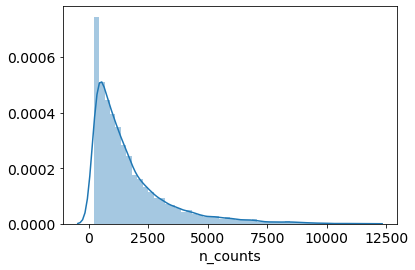

In [92]:
sns.distplot(mouse_adata.obs['n_counts'])

In [17]:
treatment = [x.split('-')[-1] for x in mouse_adata.obs['sample_id']]
mouse = [x.split('-')[-2] for x in mouse_adata.obs['sample_id']]
tumor = [x.split('-')[0] for x in mouse_adata.obs['sample_id']]

mouse_adata.obs['treatment'] = treatment
mouse_adata.obs['mouse'] = mouse
mouse_adata.obs['tumor'] = tumor

... storing 'treatment' as categorical
... storing 'mouse' as categorical
... storing 'tumor' as categorical


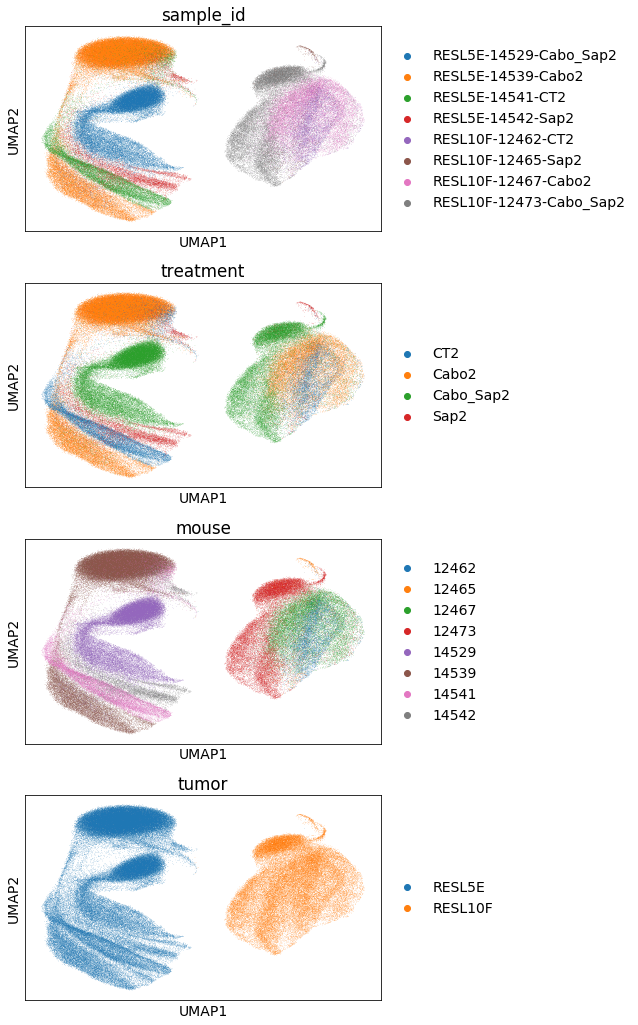

In [18]:
sc.pl.umap(mouse_adata, color=['sample_id', 'treatment', 'mouse', 'tumor'], ncols=1)

In [131]:
sc.pl.umap(mouse_adata, color=['sample_id', 'EPCAM', 'KRT18', 'CD3G', 'FLT1', 'ACTA2'], ncols=1, color_map='Reds')

KeyError: "Could not find entry in `obsm` for 'umap'.\nAvailable keys are: []."

In [ ]:
sc.pl.umap(mouse_adata, color=['sample_id', ''], ncols=1, color_map='Reds')

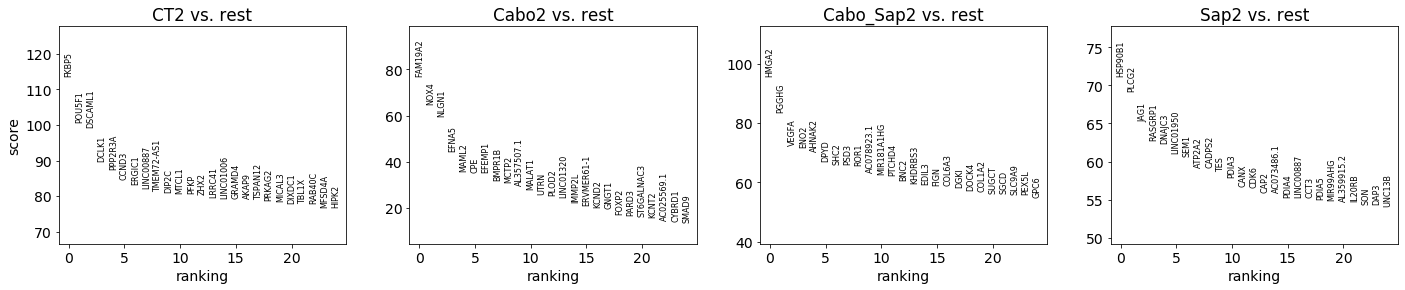

In [24]:
sc.tl.rank_genes_groups(mouse_adata, 'treatment')
sc.tl.filter_rank_genes_groups(mouse_adata)
sc.pl.rank_genes_groups(mouse_adata, n_genes=25, sharey=False)

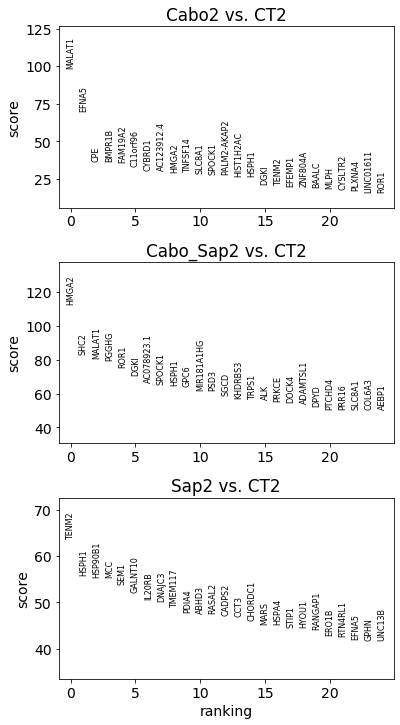

In [26]:
sc.tl.rank_genes_groups(mouse_adata, 'treatment', reference='CT2')
sc.pl.rank_genes_groups(mouse_adata, n_genes=25, sharey=False, ncols=1)